In [1]:
!pip3 install psycopg2-binary
!pip3 install pandas
!pip3 install matplotlib
!pip3 install numpy

In [2]:
%matplotlib inline
import psycopg2
import pandas as pd
import re
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_rows', 20)

In [3]:
# point this to your own postgres database if you're not using the supplied docker-compose file
pg_dsn = 'postgres://postgres@localhost:9999/postgres'

conn = psycopg2.connect(pg_dsn)
cur = conn.cursor()
# allows us to run non-transactional commands (e.g. VACUUM) below
conn.autocommit = True

In [4]:
rows = 10000
keys_per_row = 3

cur.execute("""
DROP SCHEMA IF EXISTS gin CASCADE;
CREATE SCHEMA gin;
SET search_path = gin;

CREATE TABLE example AS
SELECT 
	a AS id,
	array_agg((a-1)*%s+b) AS keys
FROM
	generate_series(1, %s) a,
	generate_series(1, %s) b
GROUP BY 1;
CREATE INDEX ON example USING GIN (keys);
""", (keys_per_row, rows, keys_per_row))
cur.execute('VACUUM ANALYZE example')

In [5]:
pd.read_sql_query('SELECT * from example ORDER BY id ASC LIMIT 5', con=conn)

,id,keys
0,1,"[1, 2, 3]"
1,2,"[4, 5, 6]"
2,3,"[7, 8, 9]"
3,4,"[10, 11, 12]"
4,5,"[13, 14, 15]"


In [6]:
cur.execute("EXPLAIN ANALYZE SELECT * FROM example WHERE keys && ARRAY[1,2,3,4,5,6]")
print('\n'.join([x[0] for x in cur.fetchall()]))

Bitmap Heap Scan on example  (cost=54.30..142.00 rows=296 width=37) (actual time=0.043..0.053 rows=2 loops=1)
  Recheck Cond: (keys && '{1,2,3,4,5,6}'::integer[])
  Heap Blocks: exact=2
  ->  Bitmap Index Scan on example_keys_idx  (cost=0.00..54.22 rows=296 width=0) (actual time=0.027..0.027 rows=2 loops=1)
        Index Cond: (keys && '{1,2,3,4,5,6}'::integer[])
Planning time: 0.120 ms
Execution time: 0.132 ms


In [7]:
# Force the query planner to use our gin index, even if it would prefer a seqscan
cur.execute("SET enable_seqscan=false")

step = 100
steps = 100
results = []
for p in range(steps):
    keys = [k+1 for k in range(step * (p+1))]
    cur.execute("EXPLAIN ANALYZE SELECT * FROM example WHERE keys && %s", (keys,))
    plan = '\n'.join([x[0] for x in cur.fetchall()])
    
    # make sure all our queries used our index
    if plan.find('Index Scan') < 0:
        raise Exception("unexpected query plan")

    time = float(re.search('Execution time: ([0-9.]+)', plan)[1])
    result = (len(keys), time)
    results.append(result)

In [8]:
df = pd.DataFrame(results, columns=["keys", "time"])
df

,keys,time
0,100,0.502
1,200,1.235
2,300,2.119
3,400,3.911
4,500,5.734
5,600,8.133
6,700,10.909
7,800,14.337
8,900,13.112
9,1000,16.135


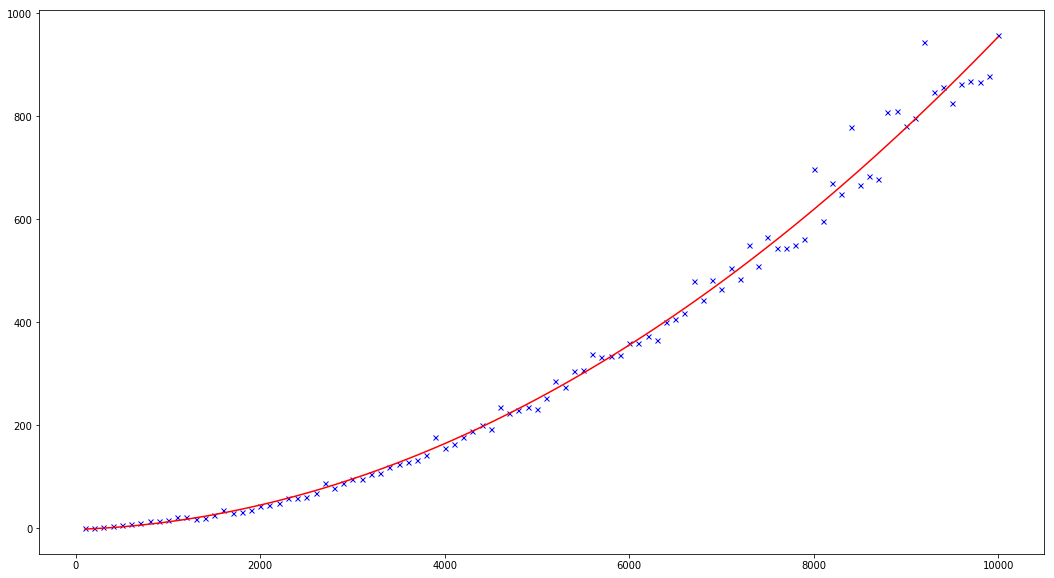

In [9]:
# plot our data and also fit a 2nd degree polynomial for illustration purposes
coefs = np.polyfit(df['keys'], df['time'], 2)
p = np.poly1d(coefs)
fig, ax = plt.subplots()
fig.set_size_inches((18, 10))
ax.plot(df['keys'], df['time'], "bx", markersize=5)
ax.plot(df['keys'], p(df['keys']), "r-") #p(X) evaluates the polynomial at X